In [1]:
import os
import cv2
import time
import random
import numpy as np
import os
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
tf.__version__, np.__version__

('2.6.2', '1.20.3')

In [3]:
# Path to the root directory containing the folders
root_dir = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images"
output_dir = "/kaggle/working/Train_Recogntion2"
os.makedirs(output_dir, exist_ok=True)

# Initialize a dictionary to keep track of the mappings
folder_to_number = {}

# Iterate through each folder in the root directory
folder_count = 0
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    # Check if it is a directory
    if os.path.isdir(folder_path):
        # Assign a number to the folder
        folder_to_number[folder] = folder_count
        folder_count += 1
        
        # Create a new folder in the output directory based on the folder number
        output_folder = os.path.join(output_dir, str(folder_to_number[folder]))
        os.makedirs(output_folder, exist_ok=True)
        
        # Rename and move the images to the new folder
        image_count = 0  # Start image numbering from 0 for each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            
            # Check if the item is an image file (optional, based on your dataset)
            if os.path.isfile(image_path):
                # Construct a new image name (e.g., 0.jpg, 1.jpg, 2.jpg)
                new_image_name = f"{image_count}.jpg"  # Change extension if needed
                
                # Move the image to the new folder
                new_image_path = os.path.join(output_folder, new_image_name)
                shutil.copy(image_path, new_image_path)
                
                # Increment image count
                image_count += 1

# Save folder to number mapping
df = pd.DataFrame(list(folder_to_number.items()), columns=["Folder Name", "Assigned Number"])
df.to_csv("folder_to_number_mapping.csv", index=False)

print("Dataset has been reorganized and images renamed successfully!")

Dataset has been reorganized and images renamed successfully!


In [4]:
# Path to the root directory containing the folders
root_dir = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images"
output_dir = "/kaggle/working/Test_Recogntion2"
os.makedirs(output_dir, exist_ok=True)

# Initialize a dictionary to keep track of the mappings
folder_to_number = {}

# Iterate through each folder in the root directory
folder_count = 0
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    # Check if it is a directory
    if os.path.isdir(folder_path):
        # Assign a number to the folder
        folder_to_number[folder] = folder_count
        folder_count += 1
        
        # Create a new folder in the output directory based on the folder number
        output_folder = os.path.join(output_dir, str(folder_to_number[folder]))
        os.makedirs(output_folder, exist_ok=True)
        
        # Rename and move the images to the new folder
        image_count = 0  # Start image numbering from 0 for each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            
            # Check if the item is an image file (optional, based on your dataset)
            if os.path.isfile(image_path):
                # Construct a new image name (e.g., 0.jpg, 1.jpg, 2.jpg)
                new_image_name = f"{image_count}.jpg"  # Change extension if needed
                
                # Move the image to the new folder
                new_image_path = os.path.join(output_folder, new_image_name)
                shutil.copy(image_path, new_image_path)
                
                # Increment image count
                image_count += 1

# Save folder to number mapping
df = pd.DataFrame(list(folder_to_number.items()), columns=["Folder Name", "Assigned Number"])
df.to_csv("folder_to_number_mapping_test.csv", index=False)

print("Dataset has been reorganized and images renamed successfully!")

Dataset has been reorganized and images renamed successfully!


In [5]:
def create_list(directory):
    folders = os.listdir(directory)
    
    random.shuffle(folders)
    
    list = {}

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        
        if os.path.isdir(folder_path):
            num_files = len(os.listdir(folder_path))  
            list[folder] = num_files  
    
    return list

In [6]:
# Call the function to create the train list
train_list = create_list("/kaggle/working/Train_Recogntion2")

# Print the length of the training list and the contents
print("Length of training list:", len(train_list))
print("Training list:", train_list)

Length of training list: 33
Training list: {'26': 40, '29': 40, '25': 40, '4': 40, '16': 40, '0': 40, '3': 40, '9': 40, '13': 40, '27': 40, '6': 40, '18': 40, '32': 40, '20': 40, '7': 40, '17': 40, '10': 40, '19': 40, '28': 40, '24': 40, '31': 40, '15': 40, '14': 40, '23': 40, '2': 40, '22': 40, '5': 40, '21': 40, '8': 40, '12': 40, '30': 40, '11': 40, '1': 40}


In [7]:
# Call the function to create the train list
test_list = create_list("/kaggle/working/Test_Recogntion2")

# Print the length of the training list and the contents
print("Length of training list:", len(test_list))
print("Training list:", test_list)

Length of training list: 33
Training list: {'4': 10, '31': 10, '32': 10, '13': 10, '22': 10, '10': 10, '24': 10, '15': 10, '20': 10, '26': 10, '18': 10, '19': 10, '1': 10, '28': 10, '11': 10, '29': 10, '23': 10, '3': 10, '2': 10, '0': 10, '12': 10, '8': 10, '17': 10, '16': 10, '14': 10, '27': 10, '21': 10, '5': 10, '30': 10, '7': 10, '6': 10, '25': 10, '9': 10}


## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [8]:
def create_triplets(directory, folder_list, max_files=40):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [9]:
train_triplet = create_triplets("/kaggle/working/Train_Recogntion2", train_list)
test_triplet  = create_triplets("/kaggle/working/Test_Recogntion2", test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 25740
Number of testing triplets : 1485

Examples of triplets:
(('9', '28.jpg'), ('9', '37.jpg'), ('8', '36.jpg'))
(('16', '1.jpg'), ('16', '7.jpg'), ('7', '18.jpg'))
(('4', '1.jpg'), ('4', '14.jpg'), ('8', '36.jpg'))
(('21', '9.jpg'), ('21', '31.jpg'), ('25', '19.jpg'))
(('11', '29.jpg'), ('11', '37.jpg'), ('21', '11.jpg'))


## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [10]:
def read_image(directory, folder, image_name, target_size=(128, 128)):
    try:
        # Construct the full file path from the directory, folder, and image name
        image_path = os.path.join(directory, folder, image_name)
        
        # Open the image file
        with Image.open(image_path) as img:
            # Resize the image to the target size
            img = img.resize(target_size)
            
            # Convert the resized image to a numpy array
            img_array = np.array(img)
            
            # Ensure the image has 3 channels (RGB)
            if img_array.ndim == 2:  # If grayscale, convert to RGB
                img_array = np.stack([img_array] * 3, axis=-1)
            elif img_array.shape[-1] != 3:  # If not RGB, convert
                img_array = img.convert('RGB')
                img_array = np.array(img_array)
            
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [11]:
def get_batch(directory, triplet_list, batch_size=32):
    batch_steps = len(triplet_list) // batch_size
    
    for i in range(batch_steps + 1):
        anchor = []
        positive = []
        negative = []
        
        j = i * batch_size
        while j < (i + 1) * batch_size and j < len(triplet_list):
            a, p, n = triplet_list[j]
            # Read images by constructing full path using directory, folder, and image name
            anchor.append(read_image(directory, a[0], a[1]))  # folder, filename
            positive.append(read_image(directory, p[0], p[1]))  # folder, filename
            negative.append(read_image(directory, n[0], n[1]))  # folder, filename
            j += 1
        
        # Convert lists to numpy arrays for batch processing
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        # Yield a batch of anchor, positive, and negative images
        yield [anchor, positive, negative]

## Plotting the Data
Plotting the data generated from get_batch() to see the results

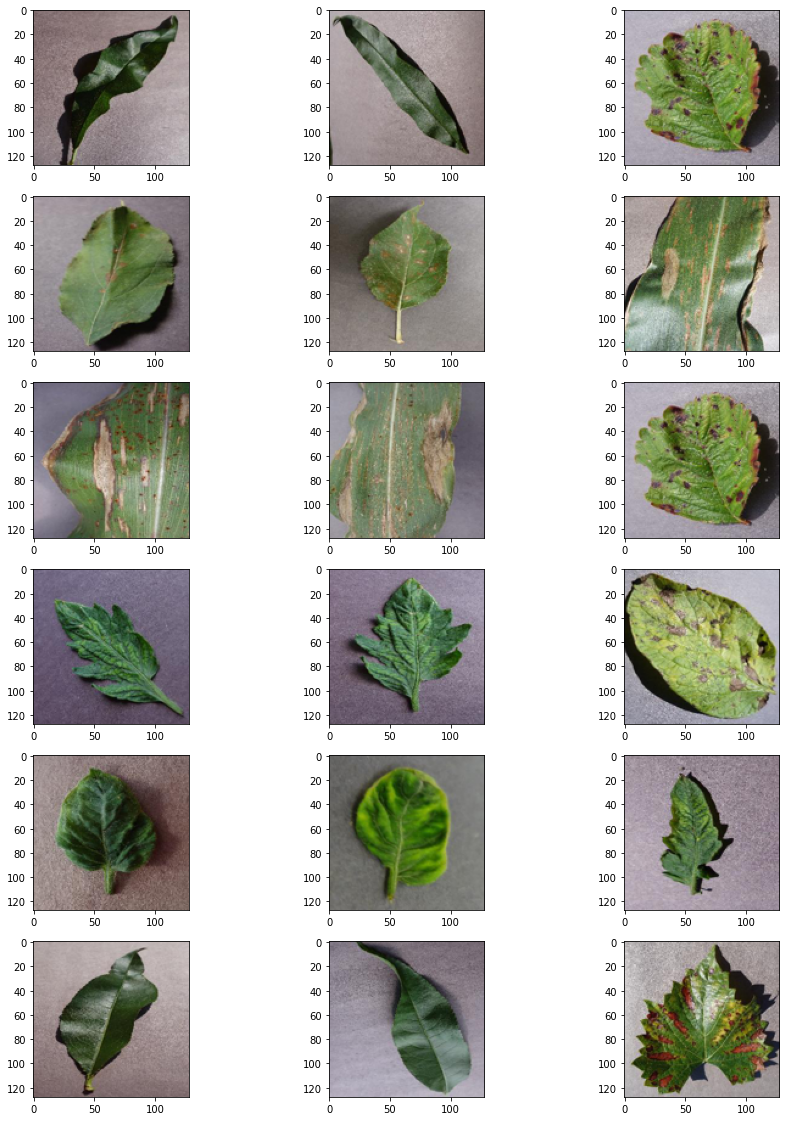

In [12]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch("/kaggle/working/Train_Recogntion2",train_triplet, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [13]:
def get_encoder(input_shape):
    """ Returns the image encoding model """
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

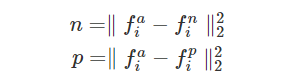

In [14]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                   

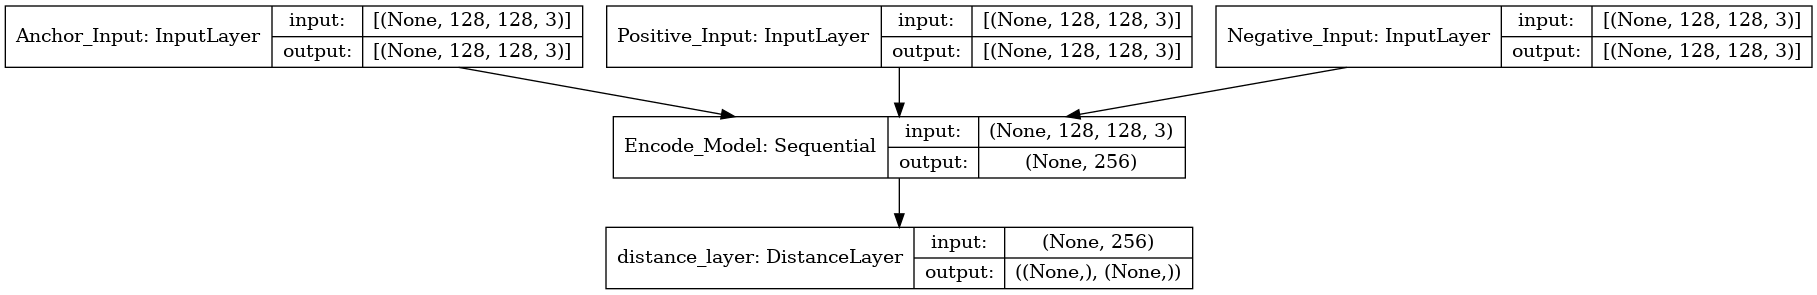

In [15]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [16]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [17]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [18]:
def test_on_triplets(batch_size = 32):
    pos_scores, neg_scores = [], []

    for data in get_batch("/kaggle/working/Test_Recogntion2",test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [19]:
save_all = False
epochs = 15
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch("/kaggle/working/Train_Recogntion2",train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 242 sec)
Loss on train    = 0.64235
Accuracy on test = 0.76296

EPOCH: 2 	 (Epoch done in 222 sec)
Loss on train    = 0.43632
Accuracy on test = 0.77980

EPOCH: 3 	 (Epoch done in 222 sec)
Loss on train    = 0.29168
Accuracy on test = 0.83502

EPOCH: 4 	 (Epoch done in 222 sec)
Loss on train    = 0.18078
Accuracy on test = 0.80875

EPOCH: 5 	 (Epoch done in 221 sec)
Loss on train    = 0.12648
Accuracy on test = 0.81818

EPOCH: 6 	 (Epoch done in 222 sec)
Loss on train    = 0.08728
Accuracy on test = 0.82963

EPOCH: 7 	 (Epoch done in 222 sec)
Loss on train    = 0.06821
Accuracy on test = 0.84108

EPOCH: 8 	 (Epoch done in 222 sec)
Loss on train    = 0.04987
Accuracy on test = 0.81953

EPOCH: 9 	 (Epoch done in 221 sec)
Loss on train    = 0.04529
Accuracy on test = 0.82357

EPOCH: 10 	 (Epoch done in 225 sec)
Loss on train    = 0.03544
Accuracy on test = 0.82424

EPOCH: 11 	 (Epoch done in 221 sec)
Loss on train    = 0.02843
Accuracy on test = 0.82492

EPOCH: 

## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [20]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)

encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
__________________________________

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [21]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.75



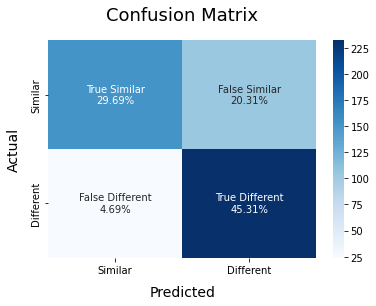

In [22]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch("/kaggle/working/Test_Recogntion2",test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)